**1. Load the dataset: The dataset will contain a single column temperature and a date column.**

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt

#Loading the dataset
data = pd.read_csv('/content/weather_data.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,temperature
0,2014-01-01,10.248357
1,2014-01-02,9.950428
2,2014-01-03,10.362958
3,2014-01-04,10.820167
4,2014-01-05,9.961091


**Preprocess the data: Normalize the temperature data and split it into training and testing sets.**

In [51]:
#Preprocessing the data
scaler = MinMaxScaler()
data['temperature_normalized'] = scaler.fit_transform(data[['temperature']])

#Splitting data into training and testing sets
train_data, test_data = train_test_split(
    data['temperature_normalized'].values, test_size=0.2, random_state=42
)

#Creating sequences
def create_sequences(data, sequence_length=30):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i : i + sequence_length])
    return np.array(sequences)

sequence_length = 30
train_sequences = create_sequences(train_data, sequence_length).reshape(-1, sequence_length, 1)
test_sequences = create_sequences(test_data, sequence_length).reshape(-1, sequence_length, 1)



**Build an LSTM Autoencoder:**

o The encoder should reduce the input dimensions to a latent representation.

o The decoder should reconstruct the input from the latent representation.


In [52]:
input_dim = train_sequences.shape[2]
inputs = Input(shape=(sequence_length, input_dim))

# Encoder
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
latent = RepeatVector(sequence_length)(encoded)

# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(latent)
outputs = TimeDistributed(tf.keras.layers.Dense(input_dim))(decoded)

# Autoencoder Model
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_10 (RepeatVector)      │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 30, 1)               │              65 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

**Train the model: Train the autoencoder on the training data and evaluate the reconstruction error on the test set.**

In [53]:
#Training the model
history = autoencoder.fit(
    train_sequences, train_sequences,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)
test_reconstructions = autoencoder.predict(test_sequences)
reconstruction_loss = np.mean(np.square(test_sequences - test_reconstructions), axis=2)  # Per timestep

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - loss: 0.1031 - val_loss: 0.0196
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0134 - val_loss: 0.0104
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0061 - val_loss: 0.0088
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - val_loss: 0.0088
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - val_loss: 0.0088
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0053 - val_loss: 0.0088
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - val_loss: 0.0088
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - val_loss: 0.0088
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - val_loss: 0.0088
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - val_loss: 0.0088
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - val_loss: 0.0088
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - 


**Anomaly Detection: Use the reconstruction error to detect anomalies. Define a threshold for the reconstruction error, and identify days where the temperature is considered anomalous.**

In [57]:
#anomaly threshold
threshold = np.percentile(reconstruction_loss, 95, axis=0)  # Per timestep threshold

#Detecting anomalies
anomalies = reconstruction_loss > threshold

#Aggregating anomaly detection per sequence
anomaly_sequences = np.any(anomalies, axis=1)

#Identification
anomaly_indices = np.where(anomaly_sequences)[0]
anomaly_dates = data['date'].iloc[anomaly_indices + sequence_length + len(train_data)]
anomaly_details = data.loc[data['date'].isin(anomaly_dates)]
print("Anomalies detected:")
print(anomaly_details)


Anomalies detected:
           date  temperature  temperature_normalized
2075 2019-09-07    10.089307                0.551156
2076 2019-09-08    10.536229                0.587637
2077 2019-09-09    10.811198                0.610082
2078 2019-09-10    10.120365                0.553691
2079 2019-09-11     9.945754                0.539438
...         ...          ...                     ...
2549 2020-12-24    10.652580                0.597135
2550 2020-12-25     8.833440                0.448641
2551 2020-12-26     8.704685                0.438131
2552 2020-12-27    10.598482                0.592719
2553 2020-12-28     9.876287                0.533767

[397 rows x 3 columns]



**Visualize the results: Plot the original temperature data and highlight the detected anomalies.**

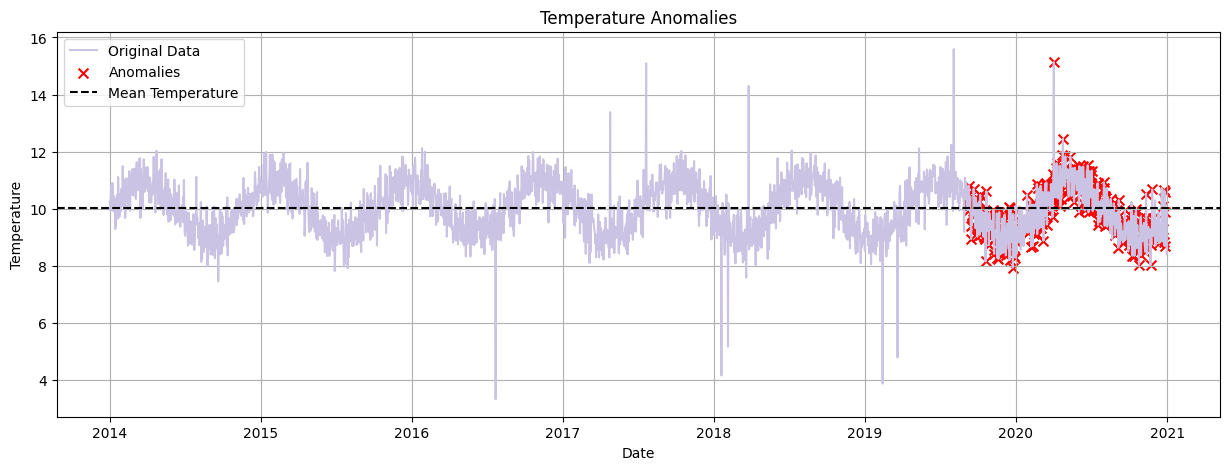

In [58]:
#Visualization
plt.figure(figsize=(15, 5))
plt.plot(data['date'], data['temperature'], label='Original Data', color='#CBC3E3')
plt.scatter(
    anomaly_dates,
    data.loc[data['date'].isin(anomaly_dates), 'temperature'],
    color='red',
    label='Anomalies',
    marker='x',
    s=50
)
plt.axhline(y=data['temperature'].mean(), color='black', linestyle='--', label='Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Anomalies')
plt.legend()
plt.grid(True)
plt.show()


**Interpretation:**

* The model flagged 397 days as anomalous based on reconstruction errors exceeding the 95th percentile threshold, indicating these days exhibited temperature patterns significantly different from the training data.

* The anomalies likely correspond to outliers in the dataset or underrepresented patterns in the training phase, which the autoencoder failed to reconstruct accurately due to the lack of similar sequences in the training set.